In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
def gaussian(x,amp,loc,sigma):
#    return amp*np.exp(-(x-loc)**2/(2*sigma**2))
    return amp*norm.pdf(x,loc,sigma)

In [3]:
def gaussians(x,*params):
    n = int(len(params)/3)
    y = 0
    for i in range(n):
        y += gaussian(x,params[i*3],params[i*3+1],params[i*3+2])
    return y

In [4]:
def random_gaussian(x,amp_range,loc_range,sigma_range,noise=0):
    rng = np.random.default_rng()
    amp = random.uniform(*amp_range)
    loc = random.uniform(*loc_range)
    scale = random.uniform(*sigma_range)
    return gaussian(x,amp,loc,scale)+amp*(rng.random(len(x))-0.5)*noise,(amp,loc,scale)

In [5]:
def fit_gaussians(xs,ys, locs):
    locs.sort()
    borders = [xs.min()]+locs+[xs.max()]
    lowers = borders[:-2]
    uppers = borders[2:]

    df = pd.DataFrame()
    df['X'] = xs
    df['Y'] = ys

    params=[]
    bounds_min = []
    bounds_max = [] 
    for loc, lower, upper in zip(locs,lowers,uppers):
        amp = df.loc[(df['X']-loc).abs().idxmin()]['Y']
        df_lower = df[(df['X']>lower) & (df['X'] < loc)]
        df_upper = df[(df['X']>loc) & (df['X'] < upper)]
        half_lower = df_lower.loc[(df_lower['Y']-amp/2).abs().idxmin()]
        half_upper = df_upper.loc[(df_upper['Y']-amp/2).abs().idxmin()]
        scale = max(abs(loc - half_lower['X']),abs(half_upper['X']-loc))/np.sqrt(2*np.log(2))
        params += [amp,loc,scale]
        bounds_min += [0,lower,0]
        bounds_max += [df['Y'].max(),upper,np.inf]
    estimate, _ = curve_fit(gaussians,xs,ys,p0=params,bounds=(bounds_min,bounds_max))
    return estimate


In [6]:
xs = np.linspace(-5,5,100)
params = [30,-1,1,
          100,0.1,0.5,
          50,1.,0.5]
rng = np.random.default_rng()
ys = gaussians(xs,*params)+(rng.random(len(xs))-0.5)*5

	Amp1	Loc1	Simga1	Amp2	Loc2	Simga2	Amp3	Loc3	Sigma3
設定	30.00	-1.00	1.00	100.00	0.10	0.50	50.00	1.00	0.50
推定	43.99	-0.67	1.05	67.99	0.03	0.44	69.83	0.82	0.56
誤差	0.5%	0.3%	0.0%	0.3%	0.7%	0.1%	0.4%	0.2%	0.1%


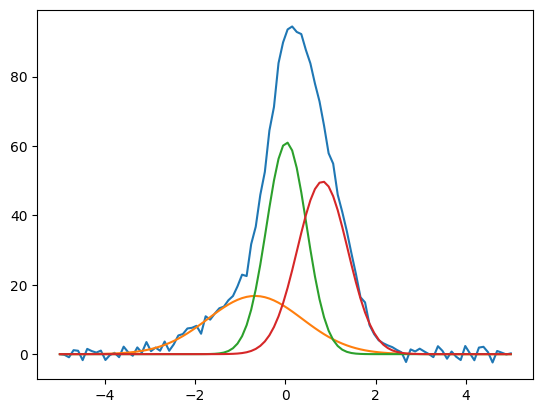

In [7]:

locs=[-1.51,0.2,1.1]
estimate = fit_gaussians(xs,ys,locs)
plt.plot(xs,ys)
for i in range(int(len(estimate)/3)):
    plt.plot(xs,gaussian(xs,*estimate[i*3:i*3+3]))

print('\tAmp1\tLoc1\tSimga1\tAmp2\tLoc2\tSimga2\tAmp3\tLoc3\tSigma3'.format(*params))
print('設定\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(*params))
print('推定\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(*estimate))
print('誤差\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%\t{:.1f}%'.format(*abs((params-estimate)/params)))